# Spaceship Titanic
### Predict which passengers are transported to an alternate dimension


Dataset Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

File and Data Field Descriptions
train.csv - Personal records for about two-thirds (aprox. 8700) of the passengers, to be used as training data.
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
test.csv - Personal records for the remaining one-third (aprox. 4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.]

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


In [123]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [124]:
df_test.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [125]:
df_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [126]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [127]:
df_not_null = df_train.dropna()

In [128]:
df_not_null.shape

(6606, 14)

In [129]:
df_train.shape

(8693, 14)

In [130]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


##### If we dropna, we will lose a substantial amount of information


##### We will need to handle the null values for each variable individually.

# EDA

### UNDERSTANDING CATEGORIC VARIABLES

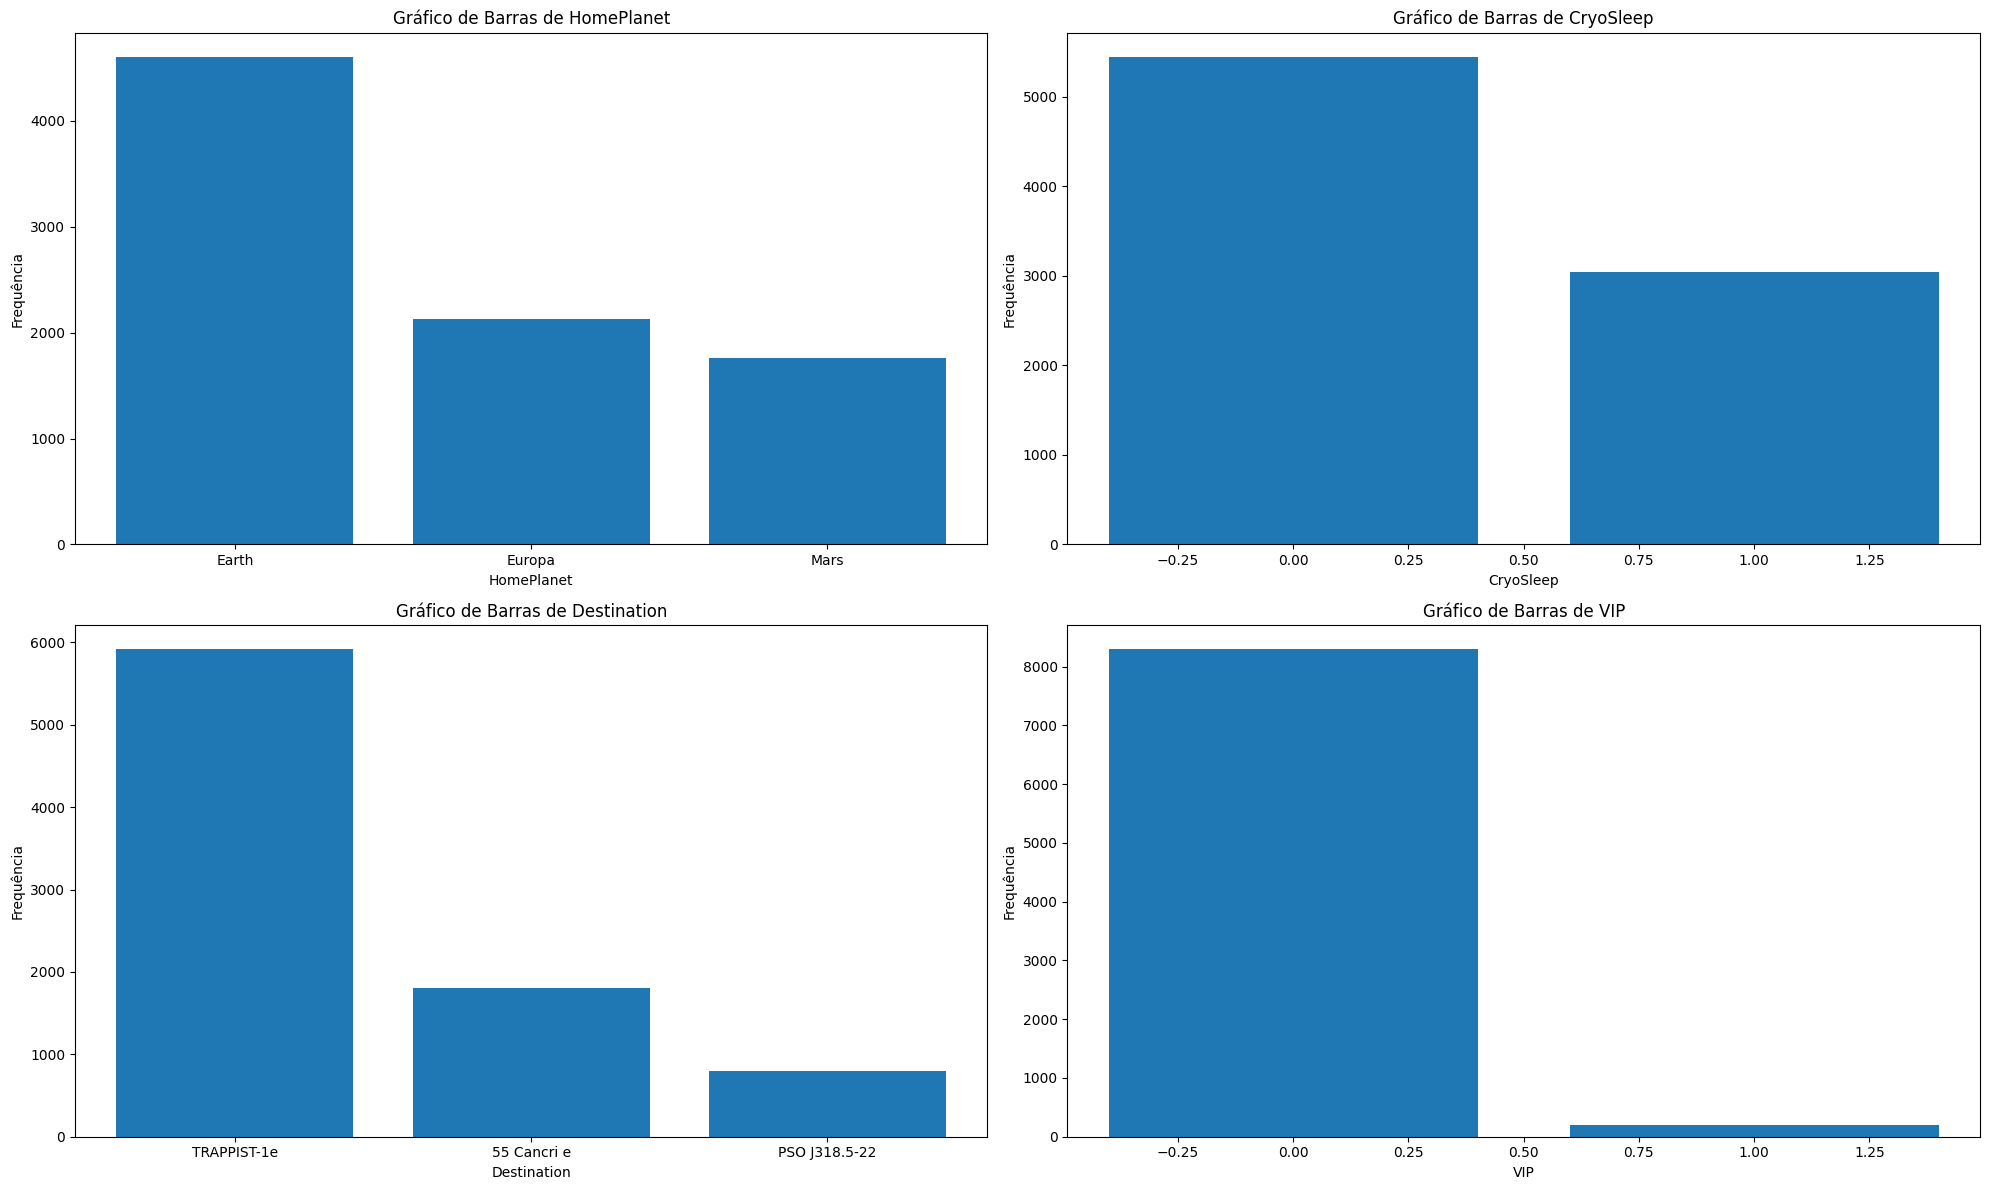

In [131]:
df_categoric = df_train[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']]
num_columns = len(df_categoric.columns)

fig, axs = plt.subplots(2, 2, figsize=(20, 6*2))

# Ao invés de usar axs[rows col], usaremos axs[i] devido ao ravel()
axs = axs.ravel()

for i, column in enumerate(df_categoric.columns):
    value_counts = df_categoric[column].dropna().value_counts()
    axs[i].bar(value_counts.index, value_counts.values)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequência')
    axs[i].set_title('Gráfico de Barras de {}'.format(column))

# Fazer com que os espaçamentos sejam ajustados automaticamente
plt.tight_layout()

plt.show()

##### Count the values of all categorical variables

In [132]:
df_counts = df_categoric.apply(pd.Series.value_counts).fillna('-')
print(df_counts)

              HomePlanet CryoSleep Destination     VIP
Earth             4602.0         -           -       -
Europa            2131.0         -           -       -
Mars              1759.0         -           -       -
False                  -    5439.0           -  8291.0
True                   -    3037.0           -   199.0
TRAPPIST-1e            -         -      5915.0       -
55 Cancri e            -         -      1800.0       -
PSO J318.5-22          -         -       796.0       -


#### CROSSTAB VISUAL

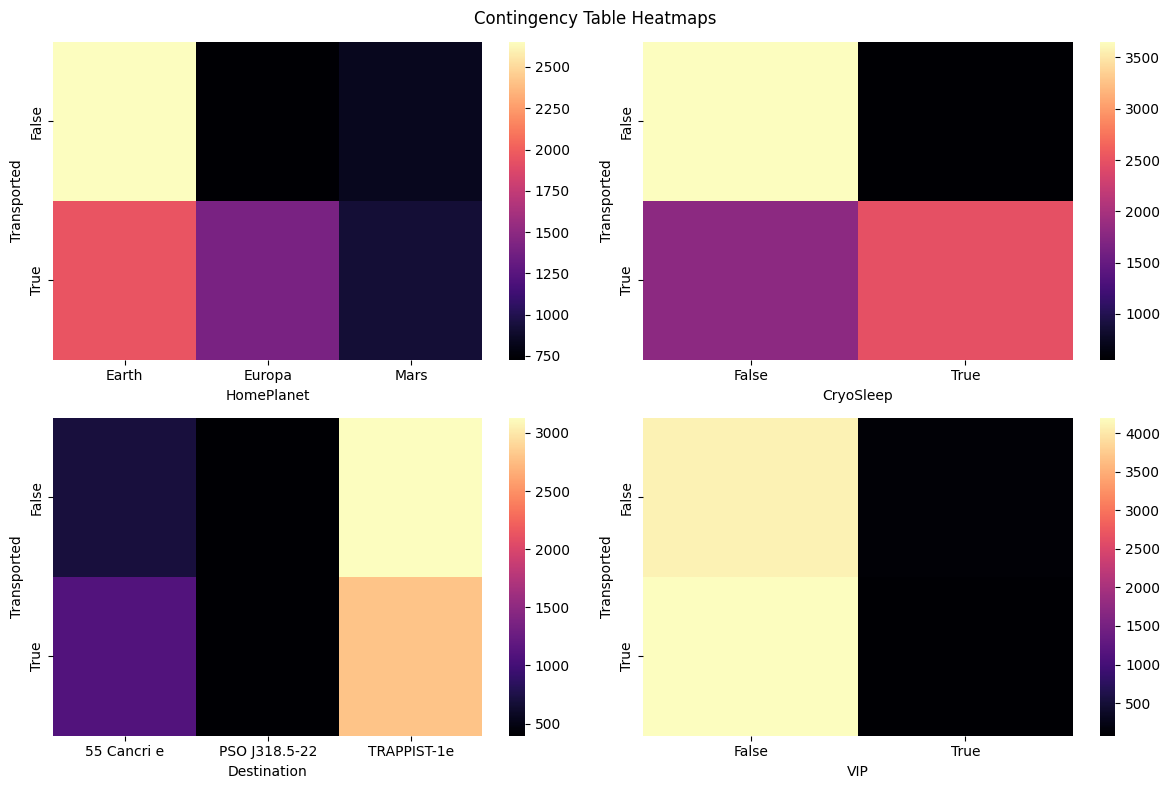

In [133]:
# Create a list of column names for subplots
columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Contingency Table Heatmaps')

# Plot heatmaps in subplots
for i, column in enumerate(columns):
    contingency_table = pd.crosstab(index=df_train['Transported'], columns=df_categoric[column])
    ax = axs[i // 2, i % 2]
    sns.heatmap(contingency_table, cmap='magma', fmt='d', ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Transported')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### Maybe we should be interested in cryosleep: true and non-VIP individuals

In [134]:
df_categoric = df_train[['HomePlanet', 'CryoSleep', 'Destination', 'VIP','Transported']]

for column in df_categoric:
    contingency_table = pd.crosstab(index=df_train['Transported'], columns=df_categoric[column])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    # Imprimir os resultados
    print("Variable:", column)
    print("Chi-square test statistic:", chi2)
    print("P-value:", p_value)
    print("Degrees of freedom:", dof)
    print("Expected frequencies:\n", np.round(expected, 1))
    print("\n--------------------------------------------- \n")


Variable: HomePlanet
Chi-square test statistic: 324.9013834000382
P-value: 2.809059985251311e-71
Degrees of freedom: 2
Expected frequencies:
 [[2285.3 1058.2  873.5]
 [2316.7 1072.8  885.5]]

--------------------------------------------- 

Variable: CryoSleep
Chi-square test statistic: 1859.6127129888841
P-value: 0.0
Degrees of freedom: 1
Expected frequencies:
 [[2697.7 1506.3]
 [2741.3 1530.7]]

--------------------------------------------- 

Variable: Destination
Chi-square test statistic: 106.39215684982227
P-value: 7.892901466137099e-24
Degrees of freedom: 2
Expected frequencies:
 [[ 893.5  395.1 2936.3]
 [ 906.5  400.9 2978.7]]

--------------------------------------------- 

Variable: VIP
Chi-square test statistic: 11.542020738162797
P-value: 0.0006804064556968345
Degrees of freedom: 1
Expected frequencies:
 [[4117.2   98.8]
 [4173.8  100.2]]

--------------------------------------------- 

Variable: Transported
Chi-square test statistic: 8689.000250089412
P-value: 0.0
Degrees of

##### All variables show significant associations with the "Transported" variable, indicating their potential influence on the transportation outcome.

### VISUALIZATION OF THE DISTRIBUTION OF NUMERIC VARIABLES

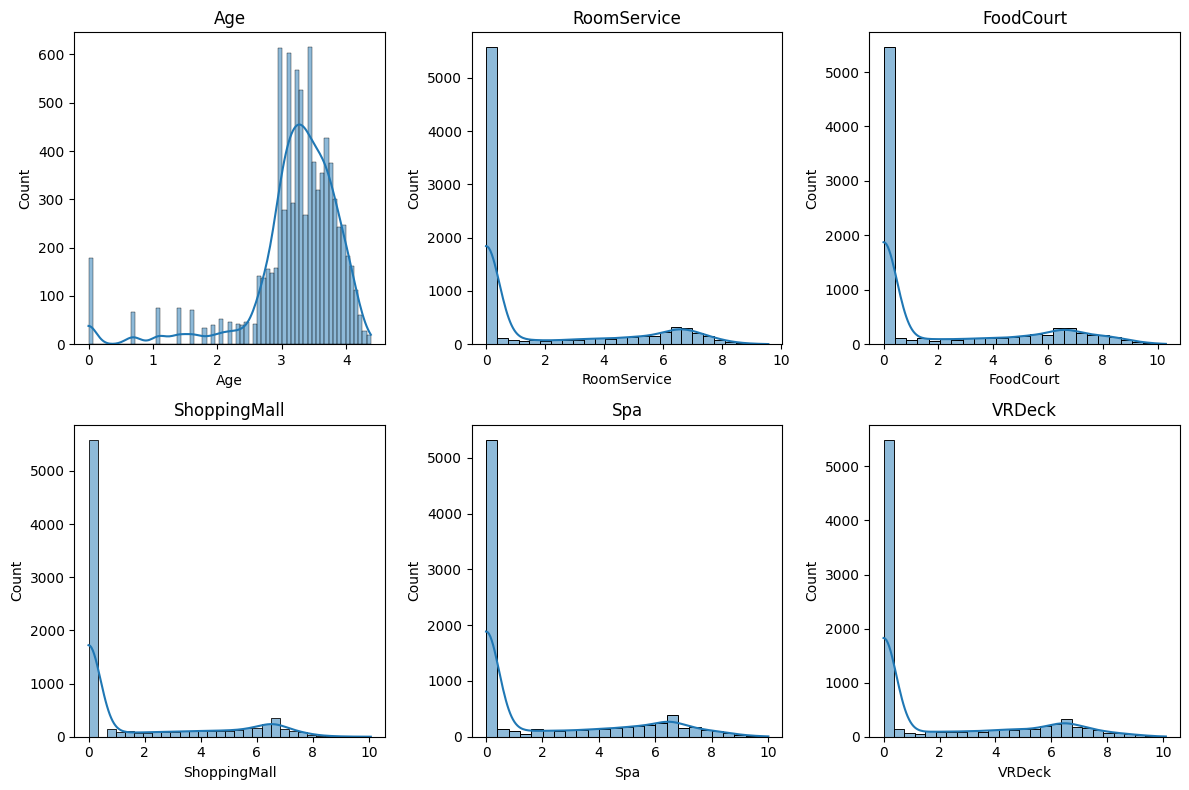

In [135]:
# DataFrame com as variáveis numéricas
df_numeric = df_train[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]

# Aplicar transformação logarítmica nas variáveis
df_numeric_log = np.log1p(df_numeric)

# Configuração do layout dos subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Iterar sobre as colunas e plotar o displot em cada subplot
for i, column in enumerate(df_numeric_log.columns):
    row = i // 3  # Índice da linha
    col = i % 3   # Índice da coluna
    ax = axes[row, col]  # Subplot atual
    
    sns.histplot(data=df_numeric_log, x=column, kde=True, ax=ax)
    ax.set_title(column)  # Definir título da variável
    
# Ajustar espaçamento entre subplots
plt.tight_layout()

# Exibir a figura
plt.show()

WE NOTE MANY VALUES AT 0.

WHICH MAY BE RELATED TO THE SOCIAL CLASS OF THOSE WHO WERE ABOARD. AS ONLY A LOW VALUE OF PEOPLE WAS VIP

In [136]:
df_numeric.corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000


In [137]:
df_numeric.isnull().sum()

Age             179
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In [138]:
df_numeric.shape

(8693, 6)

### MORE THAN 63% OF VALUES ARE ZERO. WHICH IT WOULD BE A DISASTER FOR US TO TRY TO FILL IN THESE VALUES AND EVEN WORSE IF WE IGNORE AND EXCLUDE.

VAMOS USAR ESSAS VARIAVEIS COMO CATEGÓRICA.

In [139]:
df_numeric.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


A IDADE PODEMOS DIVIDIR DE 5 EM 5 ANOS INICIALMENTE.

ENQUANTO AS DEMAIS VARIÁVEIS PODEMOS DIVIDIR A CADA PORÇÃO DE 25%

In [140]:
import pandas as pd

# DataFrame com as variáveis numéricas
df_numeric = df_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]

# Dividir as variáveis em porções de 25% e atribuir rótulos categóricos
for column in df_numeric.columns:
    df_numeric[column] = pd.cut(df_numeric[column], bins=4, labels=[1, 2, 3, 4])

# Visualizar o DataFrame resultante
print(df_numeric)

     RoomService FoodCourt ShoppingMall Spa VRDeck
0              1         1            1   1      1
1              1         1            1   1      1
2              1         1            1   2      1
3              1         1            1   1      1
4              1         1            1   1      1
...          ...       ...          ...  ..    ...
8688           1         1            1   1      1
8689           1         1            1   1      1
8690           1         1            1   1      1
8691           1         1            1   1      1
8692           1         1            1   1      1

[8693 rows x 5 columns]


C:\Users\augusto\AppData\Local\Temp\ipykernel_4276\3776690383.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric[column] = pd.cut(df_numeric[column], bins=4, labels=[1, 2, 3, 4])


C:\Users\augusto\AppData\Local\Temp\ipykernel_4276\994411952.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_numeric, x = df_numeric['FoodCourt'] )


<Axes: ylabel='Density'>

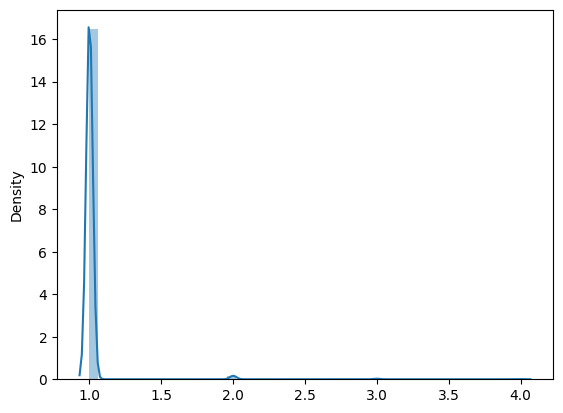

In [141]:
sns.distplot(df_numeric, x = df_numeric['FoodCourt'] )

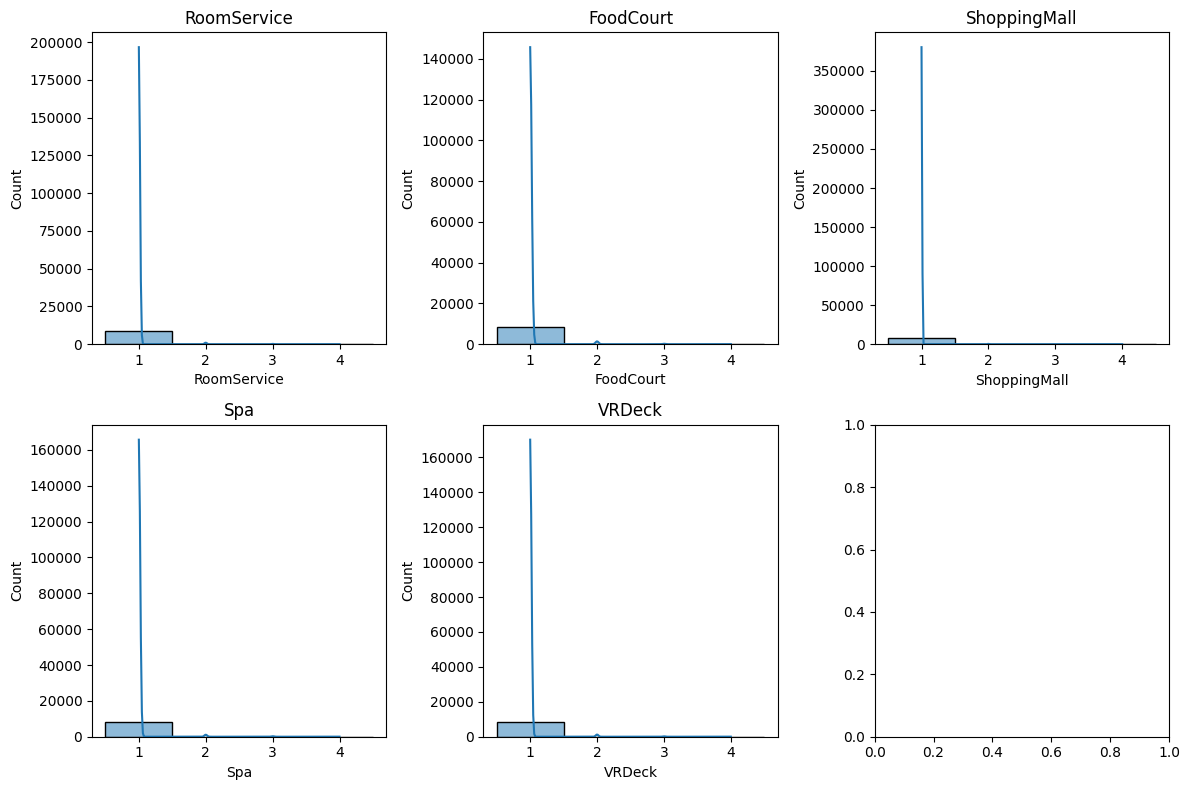

In [142]:
# Configuração do layout dos subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Iterar sobre as colunas e plotar o distplot em cada subplot
for i, column in enumerate(df_numeric.columns):
    row = i // 3  # Índice da linha
    col = i % 3   # Índice da coluna
    ax = axes[row, col]  # Subplot atual
    
    sns.histplot(data=df_numeric, x=column, kde=True, ax=ax)
    ax.set_title(column)  # Definir título da variável
    
# Ajustar espaçamento entre subplots
plt.tight_layout()

# Exibir a figura
plt.show()

THE DATA ARE VERY UNBALANCED, BUT WE WILL KEEP THE 4 CLASSES. IN CASE THIS NUMBER OF CLASSES IS RISKY, WE WILL DIVIDE INTO 2 (0 AND 1), THAT IS, YOU SPENT OR DID NOT SPEND MONEY ON A CERTAIN SERVICE

In [143]:
df_numeric.isnull().sum()

RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In [144]:
df_numeric_null = df_numeric[df_numeric.isnull().any(axis=1)]
df_numeric_null.shape

(908, 5)

In [145]:
df_numeric.value_counts()

RoomService  FoodCourt  ShoppingMall  Spa  VRDeck
1            1          1             1    1         7511
             2          1             1    1           62
             1          1             2    1           48
                                      1    2           47
2            1          1             1    1           40
1            3          1             1    1           12
             1          1             3    1           10
3            1          1             1    1            9
1            1          1             1    3            8
                        2             1    1            8
             2          1             1    2            5
                                      2    1            4
             4          1             1    1            4
             2          1             3    1            3
                                      1    3            2
             1          3             1    1            1
                      

In [146]:
agrupado = df_train.groupby(['VIP', 'HomePlanet', 'CryoSleep'])['FoodCourt'].mean()

print(agrupado)

VIP    HomePlanet  CryoSleep
False  Earth       False         197.056998
                   True            0.000000
       Europa      False        2627.767258
                   True            0.000000
       Mars        False          81.968220
                   True            0.000000
True   Europa      False        3105.271028
                   True            0.000000
       Mars        False         163.516667
Name: FoodCourt, dtype: float64


In [147]:
agrupado = df_train.groupby(['VIP', 'Age'])['FoodCourt'].mean()

print(agrupado)

VIP    Age 
False  0.0        0.0
       1.0        0.0
       2.0        0.0
       3.0        0.0
       4.0        0.0
                ...  
True   66.0    1828.0
       68.0       0.0
       69.0     269.0
       71.0       0.0
       73.0       0.0
Name: FoodCourt, Length: 126, dtype: float64


In [148]:
print(df_train.groupby(['VIP', 'HomePlanet', 'CryoSleep', 'Age'])['ShoppingMall'].mean())

VIP    HomePlanet  CryoSleep  Age 
False  Earth       False      0.0        0.0
                              1.0        0.0
                              2.0        0.0
                              3.0        0.0
                              4.0        0.0
                                       ...  
True   Mars        False      57.0     865.0
                              60.0       0.0
                              61.0       9.0
                              68.0     859.0
                              71.0    1698.0
Name: ShoppingMall, Length: 504, dtype: float64


In [149]:
agrupado = df_train.groupby(['VIP', 'Age'])['ShoppingMall'].mean()

print(agrupado)

VIP    Age 
False  0.0       0.0
       1.0       0.0
       2.0       0.0
       3.0       0.0
       4.0       0.0
               ...  
True   66.0      1.0
       68.0    859.0
       69.0      0.0
       71.0    849.0
       73.0      0.0
Name: ShoppingMall, Length: 126, dtype: float64


In [150]:
df_train.groupby(['VIP', 'HomePlanet', 'CryoSleep', 'Age'])['RoomService'].mean()

VIP    HomePlanet  CryoSleep  Age 
False  Earth       False      0.0        0.0
                              1.0        0.0
                              2.0        0.0
                              3.0        0.0
                              4.0        0.0
                                       ...  
True   Mars        False      57.0     705.0
                              60.0    2739.0
                              61.0    2353.0
                              68.0     523.0
                              71.0     901.0
Name: RoomService, Length: 504, dtype: float64

In [151]:
df_train.groupby(['VIP', 'HomePlanet', 'CryoSleep'])['Spa'].mean()

VIP    HomePlanet  CryoSleep
False  Earth       False         205.976030
                   True            0.000000
       Europa      False        1557.651830
                   True            0.000000
       Mars        False         178.259809
                   True            0.000000
True   Europa      False        1205.439252
                   True            0.000000
       Mars        False         267.031746
Name: Spa, dtype: float64

In [152]:
df_train.groupby(['VIP', 'HomePlanet', 'CryoSleep'])['VRDeck'].mean()

VIP    HomePlanet  CryoSleep
False  Earth       False         199.600609
                   True            0.000000
       Europa      False        1508.328727
                   True            0.000000
       Mars        False          77.606383
                   True            0.000000
True   Europa      False        2097.121495
                   True            0.000000
       Mars        False          59.836066
Name: VRDeck, dtype: float64

Essas informações dos gastos dos viajantes pode ser interessante para tratarmos os valores NULL dos gastos.

- Notamos que os viajantes que utilizaram o CryoSleep não gastaram durante a viagem

IndexError: index 2 is out of bounds for axis 0 with size 2

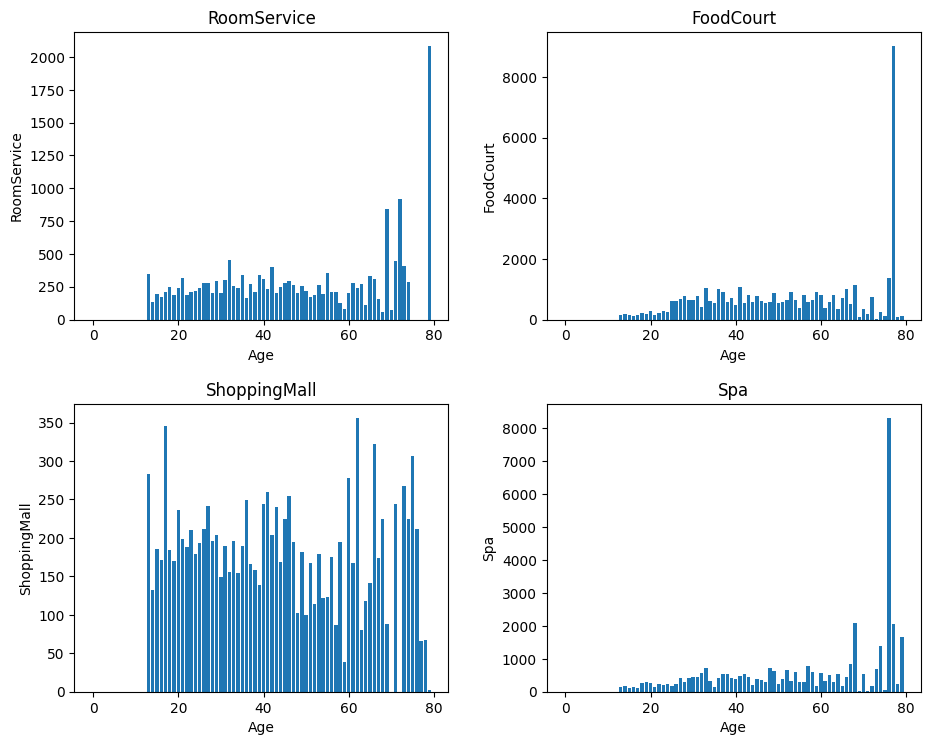

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que 'df' é o seu DataFrame contendo as colunas desejadas

# Lista das colunas a serem plotadas
colunas = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Crie uma figura e subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=4.0)

# Loop para criar os subplots e plotar os gráficos de barras
for i, coluna in enumerate(colunas):
    # Calcule as coordenadas do subplot atual
    row = i // 2  # Linha do subplot
    col = i % 2   # Coluna do subplot
    
    # Agrupe os dados pela coluna 'Age' e calcule a média da coluna atual
    agrupado = df_train.groupby('Age')[coluna].mean()
    
    # Obtenha os valores de 'Age' e as médias para o gráfico de barras
    x = agrupado.index
    y = agrupado.values
    
    # Plotar o gráfico de barras
    axs[row, col].bar(x, y)
    axs[row, col].set_xlabel('Age')
    axs[row, col].set_ylabel(coluna)
    axs[row, col].set_title(coluna)

# Ajuste os espaçamentos entre os subplots
plt.subplots_adjust(hspace=0.4)

# Exiba o gráfico
plt.show()

PODEMOS USAR TECNICAS DE REGRESSÃO PARA PREVERMOS OS MELHORES VALORES DAS VARIÁVEIS NULL

In [154]:
# Substituir os valores nulos com base nas condições: Age < 12 ou CrySleep = True então zero gastos
df_train['RoomService'] = np.where((df_train['Age'] < 12) | (df_train['CryoSleep'] == True), 0, df_train['RoomService'])
df_train['FoodCourt'] = np.where((df_train['Age'] < 12) | (df_train['CryoSleep'] == True), 0, df_train['FoodCourt'])
df_train['ShoppingMall'] = np.where((df_train['Age'] < 12) | (df_train['CryoSleep'] == True), 0, df_train['ShoppingMall'])
df_train['Spa'] = np.where((df_train['Age'] < 12) | (df_train['CryoSleep'] == True), 0, df_train['Spa'])
df_train['VRDeck'] = np.where((df_train['Age'] < 12) | (df_train['CryoSleep'] == True), 0, df_train['VRDeck'])


In [155]:
sum(df_train.isnull().sum())

1921

In [156]:
null_counts = df_train.groupby('Age')[['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].apply(lambda x: x.isnull().sum())
print(null_counts)

      RoomService  FoodCourt  ShoppingMall  Spa  VRDeck
Age                                                    
0.0             0          0             0    0       0
1.0             0          0             0    0       0
2.0             0          0             0    0       0
3.0             0          0             0    0       0
4.0             0          0             0    0       0
...           ...        ...           ...  ...     ...
75.0            0          0             0    1       0
76.0            0          0             0    0       0
77.0            0          1             0    0       0
78.0            0          0             0    0       0
79.0            0          1             0    0       0

[80 rows x 5 columns]


NOTAMOS QUE DEU CERTO SUBSTITUIR OS VALORES DOS GASTOS PARA AS CRIANÇAS MENOR DE 12 ANOS E PARA QUEM USOU O CRYOSLEEP

### USAREMOS RANDOM FOREST REGRESSOR PARA PREVER OS VALORES NULOS DOS GASTOS

In [157]:
df_train[['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age']].isnull().sum()

RoomService     108
FoodCourt       106
ShoppingMall    104
Spa             114
VRDeck          108
Age             179
dtype: int64

In [158]:
# Copiar o DataFrame original para armazenar os valores previstos
df_train_numeric = df_train[['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' , 'Age']]

df_filled = df_train_numeric.copy()
df = df_train_numeric
# Percorrer cada coluna do DataFrame
for coluna in df.columns:
    # Verificar se a coluna contém valores nulos
    if df[coluna].isnull().sum() > 0:
        # Separar os dados em dois conjuntos: com valores não nulos e com valores nulos
        df_notnull = df.dropna(subset=[coluna])
        df_null = df[df[coluna].isnull()]
        
        # Dividir o conjunto de treinamento em X e y
        X_train = df_notnull.drop(columns=[coluna])
        y_train = df_notnull[coluna]
        
        # Criar um modelo de regressão HistGradientBoosting
        modelo = HistGradientBoostingRegressor()
        
        # Treinar o modelo
        modelo.fit(X_train, y_train)
        
        # Prever os valores nulos
        X_null = df_null.drop(columns=[coluna])
        y_pred = modelo.predict(X_null)
        
        # Preencher os valores previstos nos locais corretos do DataFrame original
        df_filled.loc[df_null.index, coluna] = y_pred

# Verificar se todos os valores nulos foram preenchidos
print(df_filled.isnull().sum())

RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Age             0
dtype: int64


VERIFICANDO AS MÉDIAS PARA VER SE HOUVE UMA GRANDE VARIÂNCIA

- FOOD COURT

In [ ]:
df_filled['FoodCourt'].mean()

456.7099855646367

In [ ]:
df_train['FoodCourt'].mean()

453.96960521718876

- Spa

In [ ]:
df_filled['Spa'].mean()

311.4493925970826

In [ ]:
df_train['Spa'].mean()

308.6363212495629

- RoomService

In [ ]:
df_filled['RoomService'].mean()

224.9830197221379

In [ ]:
df_train['RoomService'].mean()

222.77705299941758

- ShoppingMall'

In [ ]:
df_filled['ShoppingMall'].mean()

172.7625491100821

In [ ]:
df_train['ShoppingMall'].mean()

171.62556758644777

- VRDeck

In [ ]:
df_filled['VRDeck'].mean()

303.6926789796413

In [ ]:
df_train['VRDeck'].mean()

302.0139778683751

In [ ]:
sum(df_filled.isnull().sum())

0

In [159]:
df_filled.head(15)

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age
0,0.0,0.0,0.0,0.0,0.0,39.0
1,109.0,9.0,25.0,549.0,44.0,24.0
2,43.0,3576.0,0.0,6715.0,49.0,58.0
3,0.0,1283.0,371.0,3329.0,193.0,33.0
4,303.0,70.0,151.0,565.0,2.0,16.0
5,0.0,483.0,0.0,291.0,0.0,44.0
6,42.0,1539.0,3.0,0.0,0.0,26.0
7,0.0,0.0,0.0,0.0,0.0,28.0
8,0.0,785.0,17.0,216.0,0.0,35.0
9,0.0,0.0,0.0,0.0,0.0,14.0


In [160]:
df_filled.shape

(8693, 6)

In [161]:
df_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### CONCATENANDO

In [162]:
# Concatenar os DataFrames usando o índice como referência
df_concatenated = pd.concat([df_filled, df_train[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Transported']]], axis=1)

# Verificar o resultado
df_concatenated.head(5)

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,HomePlanet,CryoSleep,Cabin,Destination,VIP,Transported
0,0.0,0.0,0.0,0.0,0.0,39.0,Europa,False,B/0/P,TRAPPIST-1e,False,False
1,109.0,9.0,25.0,549.0,44.0,24.0,Earth,False,F/0/S,TRAPPIST-1e,False,True
2,43.0,3576.0,0.0,6715.0,49.0,58.0,Europa,False,A/0/S,TRAPPIST-1e,True,False
3,0.0,1283.0,371.0,3329.0,193.0,33.0,Europa,False,A/0/S,TRAPPIST-1e,False,False
4,303.0,70.0,151.0,565.0,2.0,16.0,Earth,False,F/1/S,TRAPPIST-1e,False,True


In [163]:
df_encoded = pd.get_dummies(df_concatenated, columns=['Destination', 'HomePlanet'], drop_first=False)

In [164]:
df_encoded.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,CryoSleep,Cabin,VIP,Transported,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,0.0,0.0,0.0,0.0,0.0,39.0,False,B/0/P,False,False,False,False,True,False,True,False
1,109.0,9.0,25.0,549.0,44.0,24.0,False,F/0/S,False,True,False,False,True,True,False,False
2,43.0,3576.0,0.0,6715.0,49.0,58.0,False,A/0/S,True,False,False,False,True,False,True,False
3,0.0,1283.0,371.0,3329.0,193.0,33.0,False,A/0/S,False,False,False,False,True,False,True,False
4,303.0,70.0,151.0,565.0,2.0,16.0,False,F/1/S,False,True,False,False,True,True,False,False


### ANALISANDO A CABINE E VENDO SE PODEMOS ENCONTRAR ALGUM INSIGHT

In [165]:
num_cabins = df_concatenated['Cabin'].nunique()
print("Número de cabines:", num_cabins)

Número de cabines: 6560


Como temos muitas cabines, vamos dividir as colunas Cabine e destrinchar essa variável

In [166]:
df_encoded['Cabin']

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

In [167]:
df_encoded[['Cabin_letter1', 'Cabin_number', 'Cabin_letter2']] = df_encoded['Cabin'].str.split('/', expand=True)


In [168]:
df_encoded.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,CryoSleep,Cabin,VIP,Transported,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Cabin_letter1,Cabin_number,Cabin_letter2
0,0.0,0.0,0.0,0.0,0.0,39.0,False,B/0/P,False,False,False,False,True,False,True,False,B,0,P
1,109.0,9.0,25.0,549.0,44.0,24.0,False,F/0/S,False,True,False,False,True,True,False,False,F,0,S
2,43.0,3576.0,0.0,6715.0,49.0,58.0,False,A/0/S,True,False,False,False,True,False,True,False,A,0,S
3,0.0,1283.0,371.0,3329.0,193.0,33.0,False,A/0/S,False,False,False,False,True,False,True,False,A,0,S
4,303.0,70.0,151.0,565.0,2.0,16.0,False,F/1/S,False,True,False,False,True,True,False,False,F,1,S


In [169]:
df_encoded['Cabin_number'].nunique()

1817

In [170]:
df_encoded['Cabin_letter1'].nunique()

8

In [171]:
df_encoded['Cabin_letter2'].nunique()

2

In [172]:
transported_counts = df_encoded.groupby(['Cabin_letter1', 'Transported'])['Age'].count()
print(transported_counts)

Cabin_letter1  Transported
A              False           129
               True            127
B              False           207
               True            572
C              False           239
               True            508
D              False           271
               True            207
E              False           563
               True            313
F              False          1565
               True           1229
G              False          1238
               True           1321
T              False             4
               True              1
Name: Age, dtype: int64


In [173]:
transported_counts = df_encoded.groupby(['Cabin_letter2', 'Transported'])['Age'].count()
print(transported_counts)

Cabin_letter2  Transported
P              False          2308
               True           1898
S              False          1908
               True           2380
Name: Age, dtype: int64


In [174]:
transported_counts = df_encoded.groupby(['Cabin_number', 'Transported'])['Age'].count()
print(transported_counts)

Cabin_number  Transported
0             False          12
              True            6
1             False           5
              True           10
10            False           6
                             ..
997           False           2
998           False           3
              True            1
999           False           1
              True            5
Name: Age, Length: 3030, dtype: int64


In [175]:
df_encoded.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,CryoSleep,Cabin,VIP,Transported,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Cabin_letter1,Cabin_number,Cabin_letter2
0,0.0,0.0,0.0,0.0,0.0,39.0,False,B/0/P,False,False,False,False,True,False,True,False,B,0,P
1,109.0,9.0,25.0,549.0,44.0,24.0,False,F/0/S,False,True,False,False,True,True,False,False,F,0,S
2,43.0,3576.0,0.0,6715.0,49.0,58.0,False,A/0/S,True,False,False,False,True,False,True,False,A,0,S
3,0.0,1283.0,371.0,3329.0,193.0,33.0,False,A/0/S,False,False,False,False,True,False,True,False,A,0,S
4,303.0,70.0,151.0,565.0,2.0,16.0,False,F/1/S,False,True,False,False,True,True,False,False,F,1,S


In [176]:
# Mapeamento para Cabin_letter1
cabin_letter1_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
df_encoded['Cabin_letter1'] = df_encoded['Cabin_letter1'].map(cabin_letter1_mapping)

# Mapeamento para Cabin_letter2
cabin_letter2_mapping = {'P': 1, 'S': 2}
df_encoded['Cabin_letter2'] = df_encoded['Cabin_letter2'].map(cabin_letter2_mapping)


In [177]:
df_encoded.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,CryoSleep,Cabin,VIP,Transported,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Cabin_letter1,Cabin_number,Cabin_letter2
0,0.0,0.0,0.0,0.0,0.0,39.0,False,B/0/P,False,False,False,False,True,False,True,False,2.0,0,1.0
1,109.0,9.0,25.0,549.0,44.0,24.0,False,F/0/S,False,True,False,False,True,True,False,False,6.0,0,2.0
2,43.0,3576.0,0.0,6715.0,49.0,58.0,False,A/0/S,True,False,False,False,True,False,True,False,1.0,0,2.0
3,0.0,1283.0,371.0,3329.0,193.0,33.0,False,A/0/S,False,False,False,False,True,False,True,False,1.0,0,2.0
4,303.0,70.0,151.0,565.0,2.0,16.0,False,F/1/S,False,True,False,False,True,True,False,False,6.0,1,2.0


In [178]:
# Definir as colunas numéricas contínuas
numeric_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Definir o número de quantis desejado
num_quantiles = 10

# Loop para transformar as colunas numéricas em categóricas usando quantis
for col in numeric_columns:
    # Definir o nome da nova coluna categórica
    category_col = col + '_category'
    
    # Aplicar a transformação usando pd.qcut()
    df_encoded[category_col] = pd.qcut(df_encoded[col], q=num_quantiles, labels=False, duplicates='drop')

In [179]:
df_encoded.head(5)

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,CryoSleep,Cabin,VIP,Transported,...,HomePlanet_Europa,HomePlanet_Mars,Cabin_letter1,Cabin_number,Cabin_letter2,RoomService_category,FoodCourt_category,ShoppingMall_category,Spa_category,VRDeck_category
0,0.0,0.0,0.0,0.0,0.0,39.0,False,B/0/P,False,False,...,True,False,2.0,0,1.0,0,0,0,0,0
1,109.0,9.0,25.0,549.0,44.0,24.0,False,F/0/S,False,True,...,False,False,6.0,0,2.0,2,1,2,3,2
2,43.0,3576.0,0.0,6715.0,49.0,58.0,False,A/0/S,True,False,...,True,False,1.0,0,2.0,2,4,0,4,2
3,0.0,1283.0,371.0,3329.0,193.0,33.0,False,A/0/S,False,False,...,True,False,1.0,0,2.0,0,4,3,4,3
4,303.0,70.0,151.0,565.0,2.0,16.0,False,F/1/S,False,True,...,False,False,6.0,1,2.0,3,2,3,3,1


In [180]:
# Verificar os valores únicos das colunas categóricas
for col in numeric_columns:
    category_col = col + '_category'
    unique_values = df_encoded[category_col].unique()
    print(f"Valores únicos em {category_col}: {unique_values}")


Valores únicos em RoomService_category: [0 2 3 1 4]
Valores únicos em FoodCourt_category: [0 1 4 2 3]
Valores únicos em ShoppingMall_category: [0 2 3 1 4]
Valores únicos em Spa_category: [0 3 4 2 1]
Valores únicos em VRDeck_category: [0 2 3 1 4]


# SELECIONANDO AS VARIÁVEIS TRATADAS

In [181]:
df_encoded.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,CryoSleep,Cabin,VIP,Transported,...,HomePlanet_Europa,HomePlanet_Mars,Cabin_letter1,Cabin_number,Cabin_letter2,RoomService_category,FoodCourt_category,ShoppingMall_category,Spa_category,VRDeck_category
0,0.0,0.0,0.0,0.0,0.0,39.0,False,B/0/P,False,False,...,True,False,2.0,0,1.0,0,0,0,0,0
1,109.0,9.0,25.0,549.0,44.0,24.0,False,F/0/S,False,True,...,False,False,6.0,0,2.0,2,1,2,3,2
2,43.0,3576.0,0.0,6715.0,49.0,58.0,False,A/0/S,True,False,...,True,False,1.0,0,2.0,2,4,0,4,2
3,0.0,1283.0,371.0,3329.0,193.0,33.0,False,A/0/S,False,False,...,True,False,1.0,0,2.0,0,4,3,4,3
4,303.0,70.0,151.0,565.0,2.0,16.0,False,F/1/S,False,True,...,False,False,6.0,1,2.0,3,2,3,3,1


In [182]:
df_encoded['CryoSleep'] = df_encoded['CryoSleep'].map({True: 1, False: 0})
df_encoded['Transported'] = df_encoded['Transported'].map({True: 1, False: 0})
df_encoded['VIP'] = df_encoded['VIP'].map({True: 1, False: 0})
df_encoded['HomePlanet_Earth'] = df_encoded['HomePlanet_Earth'].map({True: 1, False: 0})
df_encoded['HomePlanet_Europa'] = df_encoded['HomePlanet_Europa'].map({True: 1, False: 0})
df_encoded['HomePlanet_Mars'] = df_encoded['HomePlanet_Mars'].map({True: 1, False: 0})
df_encoded['Destination_55 Cancri e'] = df_encoded['Destination_55 Cancri e'].map({True: 1, False: 0})
df_encoded['Destination_PSO J318.5-22'] = df_encoded['Destination_PSO J318.5-22'].map({True: 1, False: 0})
df_encoded['Destination_TRAPPIST-1e'] = df_encoded['Destination_TRAPPIST-1e'].map({True: 1, False: 0})

In [183]:
df_encoded.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,CryoSleep,Cabin,VIP,Transported,...,HomePlanet_Europa,HomePlanet_Mars,Cabin_letter1,Cabin_number,Cabin_letter2,RoomService_category,FoodCourt_category,ShoppingMall_category,Spa_category,VRDeck_category
0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,B/0/P,0.0,0,...,1,0,2.0,0,1.0,0,0,0,0,0
1,109.0,9.0,25.0,549.0,44.0,24.0,0.0,F/0/S,0.0,1,...,0,0,6.0,0,2.0,2,1,2,3,2
2,43.0,3576.0,0.0,6715.0,49.0,58.0,0.0,A/0/S,1.0,0,...,1,0,1.0,0,2.0,2,4,0,4,2
3,0.0,1283.0,371.0,3329.0,193.0,33.0,0.0,A/0/S,0.0,0,...,1,0,1.0,0,2.0,0,4,3,4,3
4,303.0,70.0,151.0,565.0,2.0,16.0,0.0,F/1/S,0.0,1,...,0,0,6.0,1,2.0,3,2,3,3,1


# TRATAR OS ÚLTIMOS VALORES NULOS

In [184]:
df_encoded[['Cabin_letter1', 'Cabin_number', 'Cabin_letter2']].isnull().sum()

Cabin_letter1    199
Cabin_number     199
Cabin_letter2    199
dtype: int64

### VISUALIZANDO CRYOSLEEP

DATAFRAME SÓ DE VALORES CRYOSLEEP = NaN

In [185]:
df_null_cryosleep = df_encoded.loc[df_encoded['CryoSleep'].isnull()]
df_null_cryosleep.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,CryoSleep,Cabin,VIP,Transported,...,HomePlanet_Europa,HomePlanet_Mars,Cabin_letter1,Cabin_number,Cabin_letter2,RoomService_category,FoodCourt_category,ShoppingMall_category,Spa_category,VRDeck_category
92,0.0,0.0,0.0,0.0,0.000000,2.0,NaN,G/12/P,0.0,1,...,0,0,7.0,12,1.0,0,0,0,0,0
98,0.0,0.0,570.0,2.0,131.000000,27.0,NaN,F/21/P,0.0,0,...,0,0,6.0,21,1.0,0,0,3,1,2
104,0.0,331.0,0.0,0.0,1687.000000,40.0,NaN,B/5/P,0.0,0,...,1,0,2.0,5,1.0,0,3,0,0,4
111,0.0,0.0,0.0,0.0,46.017381,26.0,NaN,F/24/P,0.0,1,...,0,1,6.0,24,1.0,0,0,0,0,2
152,0.0,985.0,0.0,5.0,0.000000,58.0,NaN,E/11/S,0.0,1,...,0,0,5.0,11,2.0,0,3,0,1,0


In [186]:
df_null_cryosleep.shape

(217, 24)

In [187]:
df_encoded

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,CryoSleep,Cabin,VIP,Transported,...,HomePlanet_Europa,HomePlanet_Mars,Cabin_letter1,Cabin_number,Cabin_letter2,RoomService_category,FoodCourt_category,ShoppingMall_category,Spa_category,VRDeck_category
0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,B/0/P,0.0,0,...,1,0,2.0,0,1.0,0,0,0,0,0
1,109.0,9.0,25.0,549.0,44.0,24.0,0.0,F/0/S,0.0,1,...,0,0,6.0,0,2.0,2,1,2,3,2
2,43.0,3576.0,0.0,6715.0,49.0,58.0,0.0,A/0/S,1.0,0,...,1,0,1.0,0,2.0,2,4,0,4,2
3,0.0,1283.0,371.0,3329.0,193.0,33.0,0.0,A/0/S,0.0,0,...,1,0,1.0,0,2.0,0,4,3,4,3
4,303.0,70.0,151.0,565.0,2.0,16.0,0.0,F/1/S,0.0,1,...,0,0,6.0,1,2.0,3,2,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,6819.0,0.0,1643.0,74.0,41.0,0.0,A/98/P,1.0,0,...,1,0,1.0,98,1.0,0,4,0,4,2
8689,0.0,0.0,0.0,0.0,0.0,18.0,1.0,G/1499/S,0.0,0,...,0,0,7.0,1499,2.0,0,0,0,0,0
8690,0.0,0.0,1872.0,1.0,0.0,26.0,0.0,G/1500/S,0.0,1,...,0,0,7.0,1500,2.0,0,0,4,1,0
8691,0.0,1049.0,0.0,353.0,3235.0,32.0,0.0,E/608/S,0.0,0,...,1,0,5.0,608,2.0,0,4,0,3,4


In [188]:
# Substituindo para 1 em CryoSleep se o viajante não gastou durante a viagem
mask = (df_encoded['RoomService'] == 0) & (df_encoded['FoodCourt'] == 0) & (df_encoded['ShoppingMall'] == 0) & (df_encoded['Spa'] == 0) & (df_encoded['VRDeck'] == 0)
df_encoded['CryoSleep'] = np.where(mask & df_encoded['CryoSleep'].isnull(), 1, df_encoded['CryoSleep'])

In [189]:
df_encoded.isnull().sum()

RoomService                    0
FoodCourt                      0
ShoppingMall                   0
Spa                            0
VRDeck                         0
Age                            0
CryoSleep                    124
Cabin                        199
VIP                          203
Transported                    0
Destination_55 Cancri e        0
Destination_PSO J318.5-22      0
Destination_TRAPPIST-1e        0
HomePlanet_Earth               0
HomePlanet_Europa              0
HomePlanet_Mars                0
Cabin_letter1                199
Cabin_number                 199
Cabin_letter2                199
RoomService_category           0
FoodCourt_category             0
ShoppingMall_category          0
Spa_category                   0
VRDeck_category                0
dtype: int64

In [190]:
df_groupby_vip = df_encoded[df_encoded['VIP'] == 0].groupby(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'VIP']).size()
print(df_groupby_vip)


RoomService    FoodCourt     ShoppingMall  Spa     VRDeck  VIP
-55.667879      0.000000      32.000000    2529.0  92.0    0.0    1
-18.941481      1632.000000   346.000000   957.0   128.0   0.0    1
-17.525179      32.000000     0.000000     4027.0  1440.0  0.0    1
 0.000000      -14.075418     115.000000   126.0   491.0   0.0    1
                0.000000     -95.454912    588.0   0.0     0.0    1
                                                                 ..
 8151.000000    2052.000000   1919.000000  7352.0  754.0   0.0    1
 8168.000000    69.000000     11.000000    371.0   0.0     0.0    1
 8586.000000    77.000000     114.000000   29.0    4.0     0.0    1
 9920.000000    0.000000      180.000000   130.0   571.0   0.0    1
 14327.000000   1487.000000   0.000000     1.0     0.0     0.0    1
Length: 4761, dtype: int64


# PRIMEIRO TESTE, UTILIZANDO O DROPNA PARA EXCLUIR O RESTANDO DOS VALORES NULOS

In [191]:
df_encoded_not_null = df_encoded.dropna()

In [192]:
df_encoded_not_null.shape

(8181, 24)

PERDEMOS EM TORNO DE 500 LINHAS DE INFORMAÇÃO. VAMOS REALIZAR A PRIMEIRA PREDIÇÃO

In [193]:
df_encoded_not_null.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,CryoSleep,Cabin,VIP,Transported,...,HomePlanet_Europa,HomePlanet_Mars,Cabin_letter1,Cabin_number,Cabin_letter2,RoomService_category,FoodCourt_category,ShoppingMall_category,Spa_category,VRDeck_category
0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,B/0/P,0.0,0,...,1,0,2.0,0,1.0,0,0,0,0,0
1,109.0,9.0,25.0,549.0,44.0,24.0,0.0,F/0/S,0.0,1,...,0,0,6.0,0,2.0,2,1,2,3,2
2,43.0,3576.0,0.0,6715.0,49.0,58.0,0.0,A/0/S,1.0,0,...,1,0,1.0,0,2.0,2,4,0,4,2
3,0.0,1283.0,371.0,3329.0,193.0,33.0,0.0,A/0/S,0.0,0,...,1,0,1.0,0,2.0,0,4,3,4,3
4,303.0,70.0,151.0,565.0,2.0,16.0,0.0,F/1/S,0.0,1,...,0,0,6.0,1,2.0,3,2,3,3,1


In [197]:
df_final = df_encoded.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin'])

In [203]:
df_final = df_final.dropna()

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def apply_classification_models(dataframe):
    # Separar as features (X) e o alvo (y)
    X = dataframe.drop(columns=['Transported'])
    y = dataframe['Transported']

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Inicializar os modelos de classificação
    models = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        KNeighborsClassifier()
    ]

    # Aplicar os modelos e imprimir as métricas de avaliação
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"Model: {type(model).__name__}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("-------------------------------")


In [210]:
apply_classification_models(df_final)


c:\Users\augusto\anaconda3\envs\PIP\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: LogisticRegression
Accuracy: 0.7917
Precision: 0.7792
Recall: 0.8180
F1 Score: 0.7981
-------------------------------
Model: DecisionTreeClassifier
Accuracy: 0.7294
Precision: 0.7223
Recall: 0.7512
F1 Score: 0.7365
-------------------------------
Model: RandomForestClassifier
Accuracy: 0.7966
Precision: 0.8119
Recall: 0.7755
F1 Score: 0.7933
-------------------------------
Model: SVC
Accuracy: 0.5510
Precision: 0.5529
Recall: 0.5643
F1 Score: 0.5586
-------------------------------
Model: KNeighborsClassifier
Accuracy: 0.6219
Precision: 0.6106
Recall: 0.6869
F1 Score: 0.6465
-------------------------------
